In [1]:
import os
import math
import json
import datetime
import numpy as np
import pandas as pd

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import levene
from scipy.ndimage import center_of_mass

def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
    def get_angular_representation(self):
        
        self.ch0_ring = []
        self.ch1_ring = []
        self.ch2_ring = []
        
        self.ringstack = []

        pixch0 = []
        pixch1 = []
        for T in range(10):
            if np.sum(self.ch3_stack[T]) > 0:
                vals = self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                pixch0 = np.hstack([pixch0, vals])
                vals = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                pixch1 = np.hstack([pixch1, vals])
        ch0_basal = np.average(pixch0)
        ch1_basal = np.average(pixch1)


        for T in range(len(self.ch3_stack)):
            try:
                outer = self.ch3_stack[T] > 0

                inner = morphology.binary_erosion(outer, selem = morphology.disk(15))
                ring = morphology.binary_erosion(outer, selem = morphology.disk(1)) & ~inner

                self.ringstack.append(ring)

                yc, xc = center_of_mass(self.ch3_stack[T])

                yy, xx = np.where(ring)
                A = np.arctan2(-(yy - yc), (xx - xc)) + self.theta
                A = np.arctan2(-np.sin(A), np.cos(A))

                F = self.ch0_stack[T][ring] - self.ch0_estimated_bg[ring]
                F /= ch0_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch0_ring.append(bs)

                F = self.ch1_stack[T][ring] - self.ch1_estimated_bg[ring]
                F /= ch1_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch1_ring.append(bs)

                bs, be, bn = stats.binned_statistic(A, self.ch2_stack[T][ring], statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch2_ring.append(bs)


            except:
                self.ch0_ring.append(np.zeros(100) + np.nan)
                self.ch1_ring.append(np.zeros(100) + np.nan)
                self.ch2_ring.append(np.zeros(100) + np.nan)
            

    

def get_tform_mat(input_bin, theta):
    '''
    Given a binary image representing a single cell and an angle,
    generate the transformation matrix that allows for rotation about
    the center of mass of the binary input by theta
    '''

    input_lbl = measure.label(input_bin)
    region = measure.regionprops(input_lbl)[0]
    y_c, x_c = region.centroid

    c = np.cos(theta)
    s = np.sin(theta)
    t_y = -y_c
    t_x = -x_c

    # translation followed by rotation
    tsl_mat = np.array([[1, 0, 0], [0, 1, 0], [t_x, t_y, 1]])
    rot_mat = np.array([[c, -s, 0],[s, c, 0],[0, 0, 1]])

    tfm_mat = np.matmul(tsl_mat, rot_mat)

    return(tfm_mat)

def get_lateral_points(input_bin, theta):
    '''
    Given a binary image representing the location of a single cell
    and the corresponding fluorescence image, calculate a polarity vector
    based on the fluorescence image and locate the lateral sides of the cell
    relative to the polarity vector
    '''

    tfm_mat = get_tform_mat(input_bin, theta)

    # collect coordinates and transform
    all_ys, all_xs = np.where(input_bin)
    all_zs = np.ones_like(all_ys)

    coords_initial = np.array([all_xs, all_ys, all_zs]).T
    coords_tformed = np.matmul(coords_initial, tfm_mat)

    x, y, z = coords_tformed.T

    # look for furthest lateral sides in transformed coordinates
    ymax = np.max(y[(x < 1) & (x > -1)])
    ymin = np.min(y[(x < 1) & (x > -1)])

    # apply inverse transformation to lateral coordinates
    x_R, y_R, placeholder = np.matmul(np.array([0, ymin, 1]), np.linalg.inv(tfm_mat))
    x_L, y_L, placeholder = np.matmul(np.array([0, ymax, 1]), np.linalg.inv(tfm_mat))

    return([x_R, y_R, x_L, y_L])

In [2]:
# Collect paths to data in memory - this is needed to run most code blocks below
# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['_lateral90_', '_lateral45_', '_front_', '_global_']

DATA = []
for condition in different_conditions:
    print(f'finding paths containing: "{condition}"' + '\n')
    # collect local list of paths to experiments to pool together for display
    for i in os.listdir('/home/jason/Data/simpleStimData/'):
        if (condition in i):
            print(i)
            DATA.append('/home/jason/Data/simpleStimData/' + i)
        if (condition == '_lateral90_') and ('_0Rad_' in i):
            print(i)
            DATA.append('/home/jason/Data/simpleStimData/' + i)

DATA = np.array(DATA)
for condition in different_conditions:
    print(condition, np.sum([condition in i for i in DATA]))

finding paths containing: "_lateral90_"

220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_003
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_011
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
220228_KWC_35-52-97_simpleStimScreen_well2_lateral90_50000_Intensity_000
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_004
220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_001
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_008
220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_001
211121_KWC_35-5

# Figure 2A

finding paths containing: "_lateral90_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_002 302
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003 300
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_011 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_009 302
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013 300
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_lateral90_50000_Intensity_000 300
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007 300
/home/jason/Dat

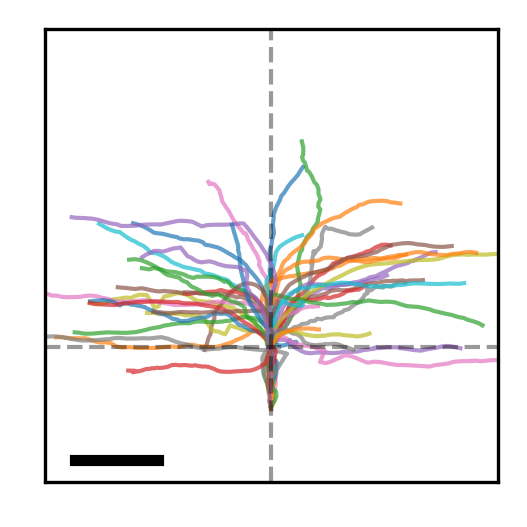

In [3]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################


different_conditions = ['_lateral90_']


exp_cond = []
file_id = []
file_id_num = []
frame = []
time = []
x_um = []
y_um = []

for condition in different_conditions:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    
    if (condition == '_lateral90_'):
        for i in DATA:
            if (condition in i) or ('_0Rad_' in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
        
    else:
        for i in DATA:
            if (condition in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)

                
                
                
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (2,2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder - something strange happens with some filenames and these need to be "decoded"
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        # fluorescence channel
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []
        t_stage_sequence = []
        
        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])
                tval = float(temptif.shaped_metadata[0]['elapsed_time_s'])
                
                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
                t_stage_sequence.append(tval)
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)

        plt.plot(x_rotated, y_rotated, alpha = 0.7, lw = 1)
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
         
        for ix in range(len(x_rotated)):
            exp_cond.append(condition)
            file_id.append(exp_to_analyze[fnum].split('/')[-1])
            file_id_num.append(fnum)
            frame.append(ix)
            time.append(t_stage_sequence[ix])
            x_um.append(x_rotated[ix])
            y_um.append(y_rotated[ix])
        
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-125, 125, -75, 175])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)
    


    rect = mp.Rectangle((-110, -65), 50, 4, color = 'k')
    ax.add_patch(rect)
    #ax.text(-120 + 50/2, -110, '50 µm', ha = 'center', va = 'bottom', fontweight='bold')
    plt.show()
    #txt = str(np.round(a.ch0_times[i] - a.ch0_times[10], 1))
    #ax.text(-100, 115, txt + ' s', va = 'top', ha = 'right', fontweight='bold')
    

# Figure 2B

In [5]:
path = '/home/jason/Data/simpleStimData/'
lateral90paths = [path + i for i in os.listdir(path) if ('_lateral90_' in i)|('_0Rad_' in i)]
print(len(lateral90paths))

46


In [14]:
# collect "ring" data. i.e. collect data around the periphery of each cell as it moves
# this lets us standardize the frame of ref for this data to average it together

ALL_ch0 = []
ALL_ch1 = []
ALL_ch2 = []

for filenum in range(len(lateral90paths)):
    
    a = simpleStimData(lateral90paths[filenum])
    a.get_angular_representation()
    
    # standardize data by flipping data in x direction for cells that end up going one way
    if a.x_rotated[-1] > 0:
        ALL_ch0.append(a.ch0_ring)
        ALL_ch1.append(a.ch1_ring)
        ALL_ch2.append(a.ch2_ring)
    else:
        ALL_ch0.append(np.fliplr(a.ch0_ring))
        ALL_ch1.append(np.fliplr(a.ch1_ring))
        ALL_ch2.append(np.fliplr(a.ch2_ring))

        

/home/jason/.local/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


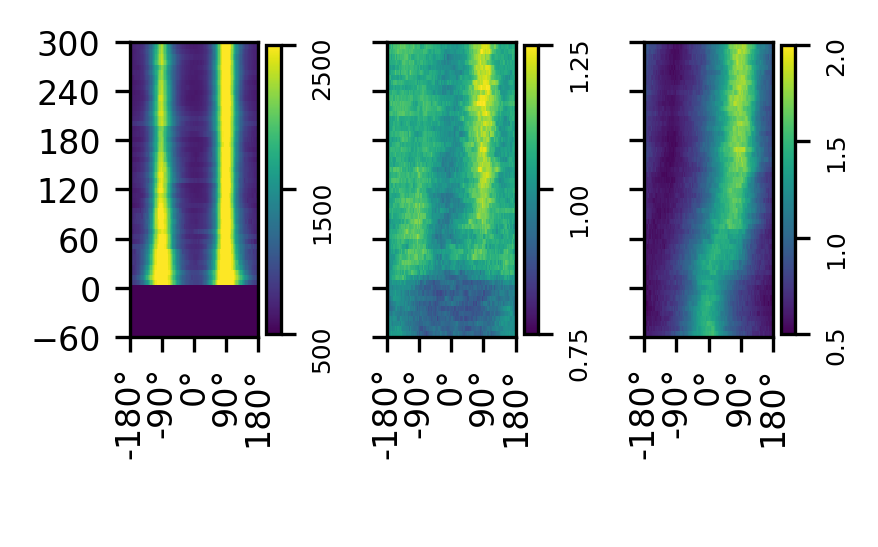

In [15]:
plt.figure(figsize = (3., 3), dpi = 300)

plt.subplot(131, aspect = 0.04)
y = a.ch1_times- a.ch1_times[10]
x = np.linspace(-math.pi, math.pi, 101)[:-1]
x += (x[1] - x[0])/2 # center
plt.pcolormesh(x, y, np.fliplr(np.nanmean(ALL_ch2, axis = 0)), vmin = 500, vmax = 2500)
plt.xticks([-math.pi, -math.pi/2, 0, math.pi/2, math.pi], ['-180°', '-90°', '0°', '90°', '180°'], fontsize = 8, rotation = 'vertical')
plt.yticks([-60, 0, 60, 120, 180, 240, 300], fontsize = 8)
plt.ylim(-60, 300)
cbar = plt.colorbar(orientation = 'vertical', location = 'right', ticks = [500, 1500, 2500], shrink = 0.37)
cbar.ax.tick_params(labelsize=6, rotation = 90)


plt.subplot(132, aspect = 0.04)
y = a.ch1_times- a.ch1_times[10]
x = np.linspace(-math.pi, math.pi, 101)[:-1]
x += (x[1] - x[0])/2 # center
plt.pcolormesh(x, y, np.fliplr(np.nanmean(ALL_ch1, axis = 0)), vmin = 0.75, vmax = 1.25)
plt.xticks([-math.pi, -math.pi/2, 0, math.pi/2, math.pi], ['-180°', '-90°', '0°', '90°', '180°'], fontsize = 8, rotation = 'vertical') #, -math.pi/2, 0, math.pi/2, math.pi]
plt.yticks([-60, 0, 60, 120, 180, 240, 300], ['','','','','','',''], fontsize = 8)
plt.ylim(-60, 300)
cbar = plt.colorbar(orientation = 'vertical', location = 'right', ticks = [0.75, 1. , 1.25], shrink = 0.37)
cbar.ax.tick_params(labelsize=6, rotation = 90)

plt.subplot(133, aspect = 0.04)
y = a.ch0_times- a.ch0_times[10]
x = np.linspace(-math.pi, math.pi, 101)[:-1]
x += (x[1] - x[0])/2 # center
plt.pcolormesh(x, y, np.fliplr(np.nanmean(ALL_ch0, axis = 0)), vmin = 0.5, vmax = 2)
plt.xticks([-math.pi, -math.pi/2, 0, math.pi/2, math.pi], ['-180°', '-90°', '0°', '90°', '180°'], fontsize = 8, rotation = 'vertical')
plt.yticks([-60, 0, 60, 120, 180, 240, 300], ['','','','','','',''], fontsize = 8)
plt.ylim(-60, 300)
plt.xlabel(' ')
cbar = plt.colorbar(orientation = 'vertical', location = 'right', ticks = [0.5, 1, 1.5, 2], shrink = 0.37)
cbar.ax.tick_params(labelsize=6, rotation = 90)

plt.tight_layout()
plt.show()

([<matplotlib.axis.YTick at 0x7f78b7684e80>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

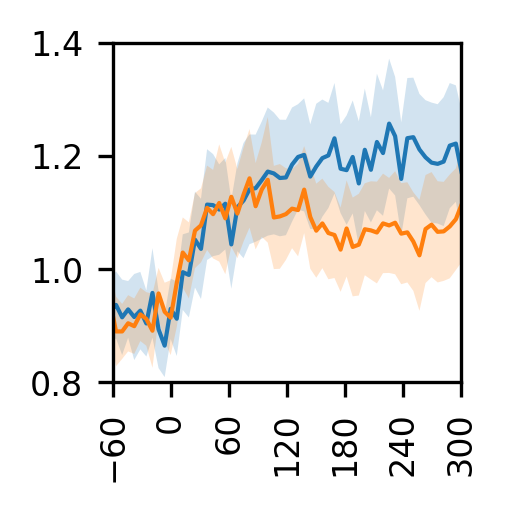

In [16]:
plt.figure(figsize = (1.5, 1.5), dpi = 300)
X = np.fliplr(np.nanmean(ALL_ch1, axis = 0))
S = 1.96*np.fliplr(np.nanstd(ALL_ch1, axis = 0))/np.sqrt(len(ALL_ch1))

T = a.ch0_times- a.ch0_times[10]

plt.plot(T, X[:,75], lw = 1)
plt.fill_between(T, X[:,75] - S[:,75], X[:,75] + S[:,75], alpha = 0.2)
plt.xlim(-60, 300)

plt.plot(T, X[:,25], lw = 1)
plt.fill_between(T, X[:,25] - S[:,25], X[:,25] + S[:,25], alpha = 0.2)

#plt.axhline(1, color = 'k', ls = '--', lw = 1)
plt.xlim(-60, 300)
plt.ylim(0.8, 1.4)

plt.xticks([-60, 0, 60, 120, 180, 240, 300], fontsize = 8, rotation = 'vertical')
plt.yticks([0.8, 1, 1.2, 1.4], fontsize = 8)

# Figure 2C

In [31]:
proportions_across_data = []
num_turning = []
cutoff = 20

angles = np.array([0, math.pi/16, math.pi/8, math.pi/4, math.pi/2])

count = 0
for delay in ['_0Rad_', '_0.2Rad_', '_0.39Rad_', '_0.79Rad_', '_1.57Rad_']:
    
    print(delay)
    
    
    exp_to_analyze = []

    parent_dir = '/home/jason/Data/simpleStimData/'
    for i in os.listdir(parent_dir):
        if (delay in i):
            print(i)
            exp_to_analyze.append(parent_dir + i)
            
        # special case because of messy naming: for 0Rad case, include other lateral 90 experiments
        if delay == '_0Rad_':
            if '_lateral90_50000' in i:
                exp_to_analyze.append(parent_dir + i)
                    
    exp_to_analyze = np.sort(exp_to_analyze)

    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]

        im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])

        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:

                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)

        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]

        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2 - angles[count]

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        final_loc = x_rotated[-1]
        
            
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)

    final_loc = np.array([i[-1] for i in ALL_X_PATHS])


    left = np.sum(final_loc < -cutoff)
    neither = np.sum(np.abs(final_loc) < cutoff)
    right = np.sum(final_loc > cutoff)
    
    proportion_right = right/(left + right)
    proportions_across_data.append(proportion_right)
    num_turning.append(left + right)
    
    count += 1
    
    
proportions_across_data = np.array(proportions_across_data)

_0Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_005
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_004
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_009
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_012
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_006
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_014
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_001
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_015
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_010
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_002
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_017
_0.2Rad_
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_016
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_003
211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0.2Rad_008
211121_KWC_35-52-97mcPAK_twoSpot_angleTest

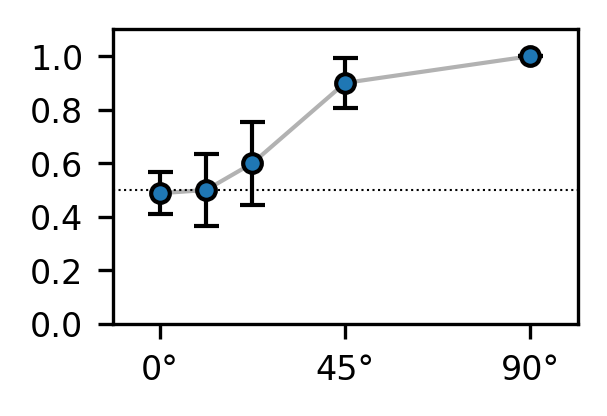

0.0 Rad, X: 0.49
0.2 Rad, X: 0.5
0.39 Rad, X: 0.6
0.79 Rad, X: 0.9
1.57 Rad, X: 1.0
[0.15300476 0.26191602 0.30364189 0.18594193 0.        ]


In [32]:
#Standard Error of Sample Proportion
sample_error = np.sqrt(proportions_across_data * (1 - proportions_across_data) / num_turning)
percent_confidence_interval_95 = 1.96 * sample_error


plt.figure(figsize = (2, 1.3), dpi = 300)
ax = plt.subplot()
plt.scatter(angles, proportions_across_data, zorder = 1, s = 20, lw = 1, ec = 'k')
plt.plot(angles, proportions_across_data, zorder = 0, alpha = 0.3, lw = 1, color = 'k')
plt.errorbar(angles, proportions_across_data, sample_error, color = 'k', zorder = 0, lw = 1, capsize = 3, ls = 'none')

plt.ylim(0.0, 1.1)

plt.xlim(-0.2, math.pi/2 + 0.2)
plt.xticks([0, math.pi/4, math.pi/2], ['0°', '45°', '90°'], fontsize = 8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 8)
plt.axhline(0.5, ls = ':', color = 'k', zorder = -1, lw = 0.5)
plt.show()

for i, p in enumerate(proportions_across_data):
    print(str(np.round(angles[i], 2)) + ' Rad,', 'X: ' + str(np.round(p, 2)))
    
print(percent_confidence_interval_95)

In [20]:
from scipy.stats import binom_test

for i in range(len(proportions_across_data)):
    p = binom_test(int(proportions_across_data[i] * num_turning[i]), n=num_turning[i], p=0.5)
    print(np.round(p, 2))

1.0
1.0
0.75
0.02
0.03


# Figure 2D

Stimulation:  lateral90


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


-49.9
6.300000000000004
62.4
118.6
174.79999999999998
230.9
287.1


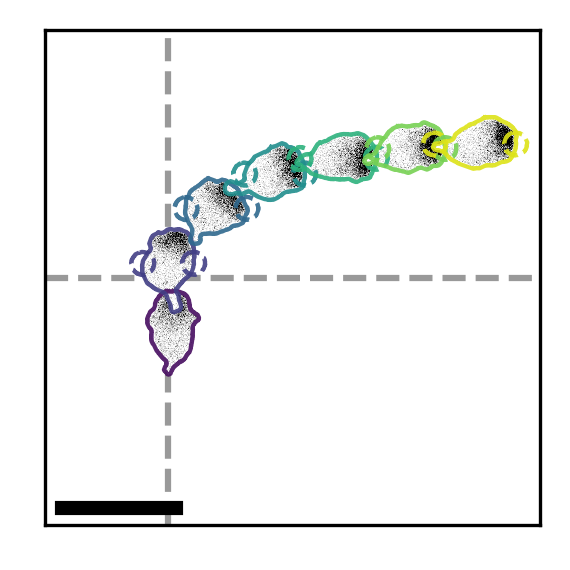

Stimulation:  lateral45


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


-50.0
6.299999999999997
62.599999999999994
118.80000000000001
175.1
231.39999999999998
287.7


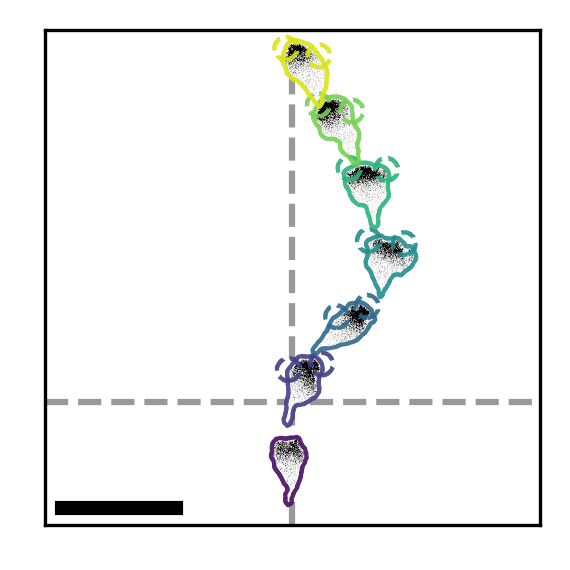

In [21]:
# paths to example single cell traces
path6 = '/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_004/'
path7 = '/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_001/'


# appropriate axis limits for each of the cells
ax6 = [-50, 150, -100, 100]
ax7 = [-100, 100, -50, 150]

paths = [path6, path7]
axs = [ax6, ax7]
condition = ['lateral90', 'lateral45']

BY = 9 # how many frames to skip between shown stills

for count in range(2):
    
    print('Stimulation: ', condition[count])
    
    a = simpleStimData(paths[count])
    fig = plt.figure(figsize = (2,2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')

    cmap = cm.get_cmap('viridis')
    col_vec = [cmap(i) for i in np.linspace(0, 1, len(a.ch3_stack))]
    
    
    # plot the transformed pixel intensity data at the different time points
    for i in range(2, len(a.ch3_stack), BY):
        xx, yy = a.get_transformed_xy_coords(i) # rotate to standardize initial direction of cell motion
        F = a.ch0_stack[i].copy()
        F[a.ch3_stack[i] == 0] = np.nan # white-out the background
        plt.pcolormesh(xx, yy, F, vmin = 500, vmax = 900, cmap = 'Greys') #show pixel data
    
    # add outlines for segmented cell and contour of light-based activation
    # color code these based on the timing
    for i in range(2, len(a.ch3_stack), BY):
        print(a.ch0_times[i] - a.ch0_times[10])
        # ch3 stack has segmented cell outlines
        contours = measure.find_contours(a.ch3_stack[i] > 0, level = False) 
        mat = a.transform_mats[i]
        for ctr in contours:
            y_pixel, x_pixel = ctr.T
            placeholder = np.ones_like(x_pixel)
            ctr_px = np.array([x_pixel, y_pixel, placeholder])
            y_um, x_um, placeholder = np.matmul(mat, ctr_px)
            plt.plot(x_um, y_um, color = col_vec[i], alpha = 0.9, linewidth = 1, zorder = 1)
        
        # ch4 stack has spatial light data
        contours = measure.find_contours(a.ch4_stack[i] > 0, level = False)
        mat = a.transform_mats[i]
        for ctr in contours:
            y_pixel, x_pixel = ctr.T
            placeholder = np.ones_like(x_pixel)
            ctr_px = np.array([x_pixel, y_pixel, placeholder])
            y_um, x_um, placeholder = np.matmul(mat, ctr_px)
            plt.plot(x_um, y_um, color = col_vec[i], alpha = 0.9, zorder = 1, linestyle = '--', linewidth = 1)
    
    # add axis lines at the origin - defined as the location where cells experience the first activation
    # (this is derived from the transformation matrices saved in the image metadata and is a consequence
    # of doing live-cell tracking during the experiments)
    plt.axhline(0, ls = '--', alpha = 0.4, color = 'k', zorder = -1)
    plt.axvline(0, ls = '--', alpha = 0.4, color = 'k', zorder = -1)

    # set axis limits
    plt.axis(axs[count])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    
    rect = mp.Rectangle((axs[count][0] + 5, axs[count][2] + 5), 50, 4, color = 'k')
    ax.add_patch(rect)
    
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)

    plt.tight_layout()
    plt.show()



finding paths containing: "_lateral90_50000_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_002 302
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003 300
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_011 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_009 302
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013 300
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_lateral90_50000_Intensity_000 300
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007 300
/home/jas

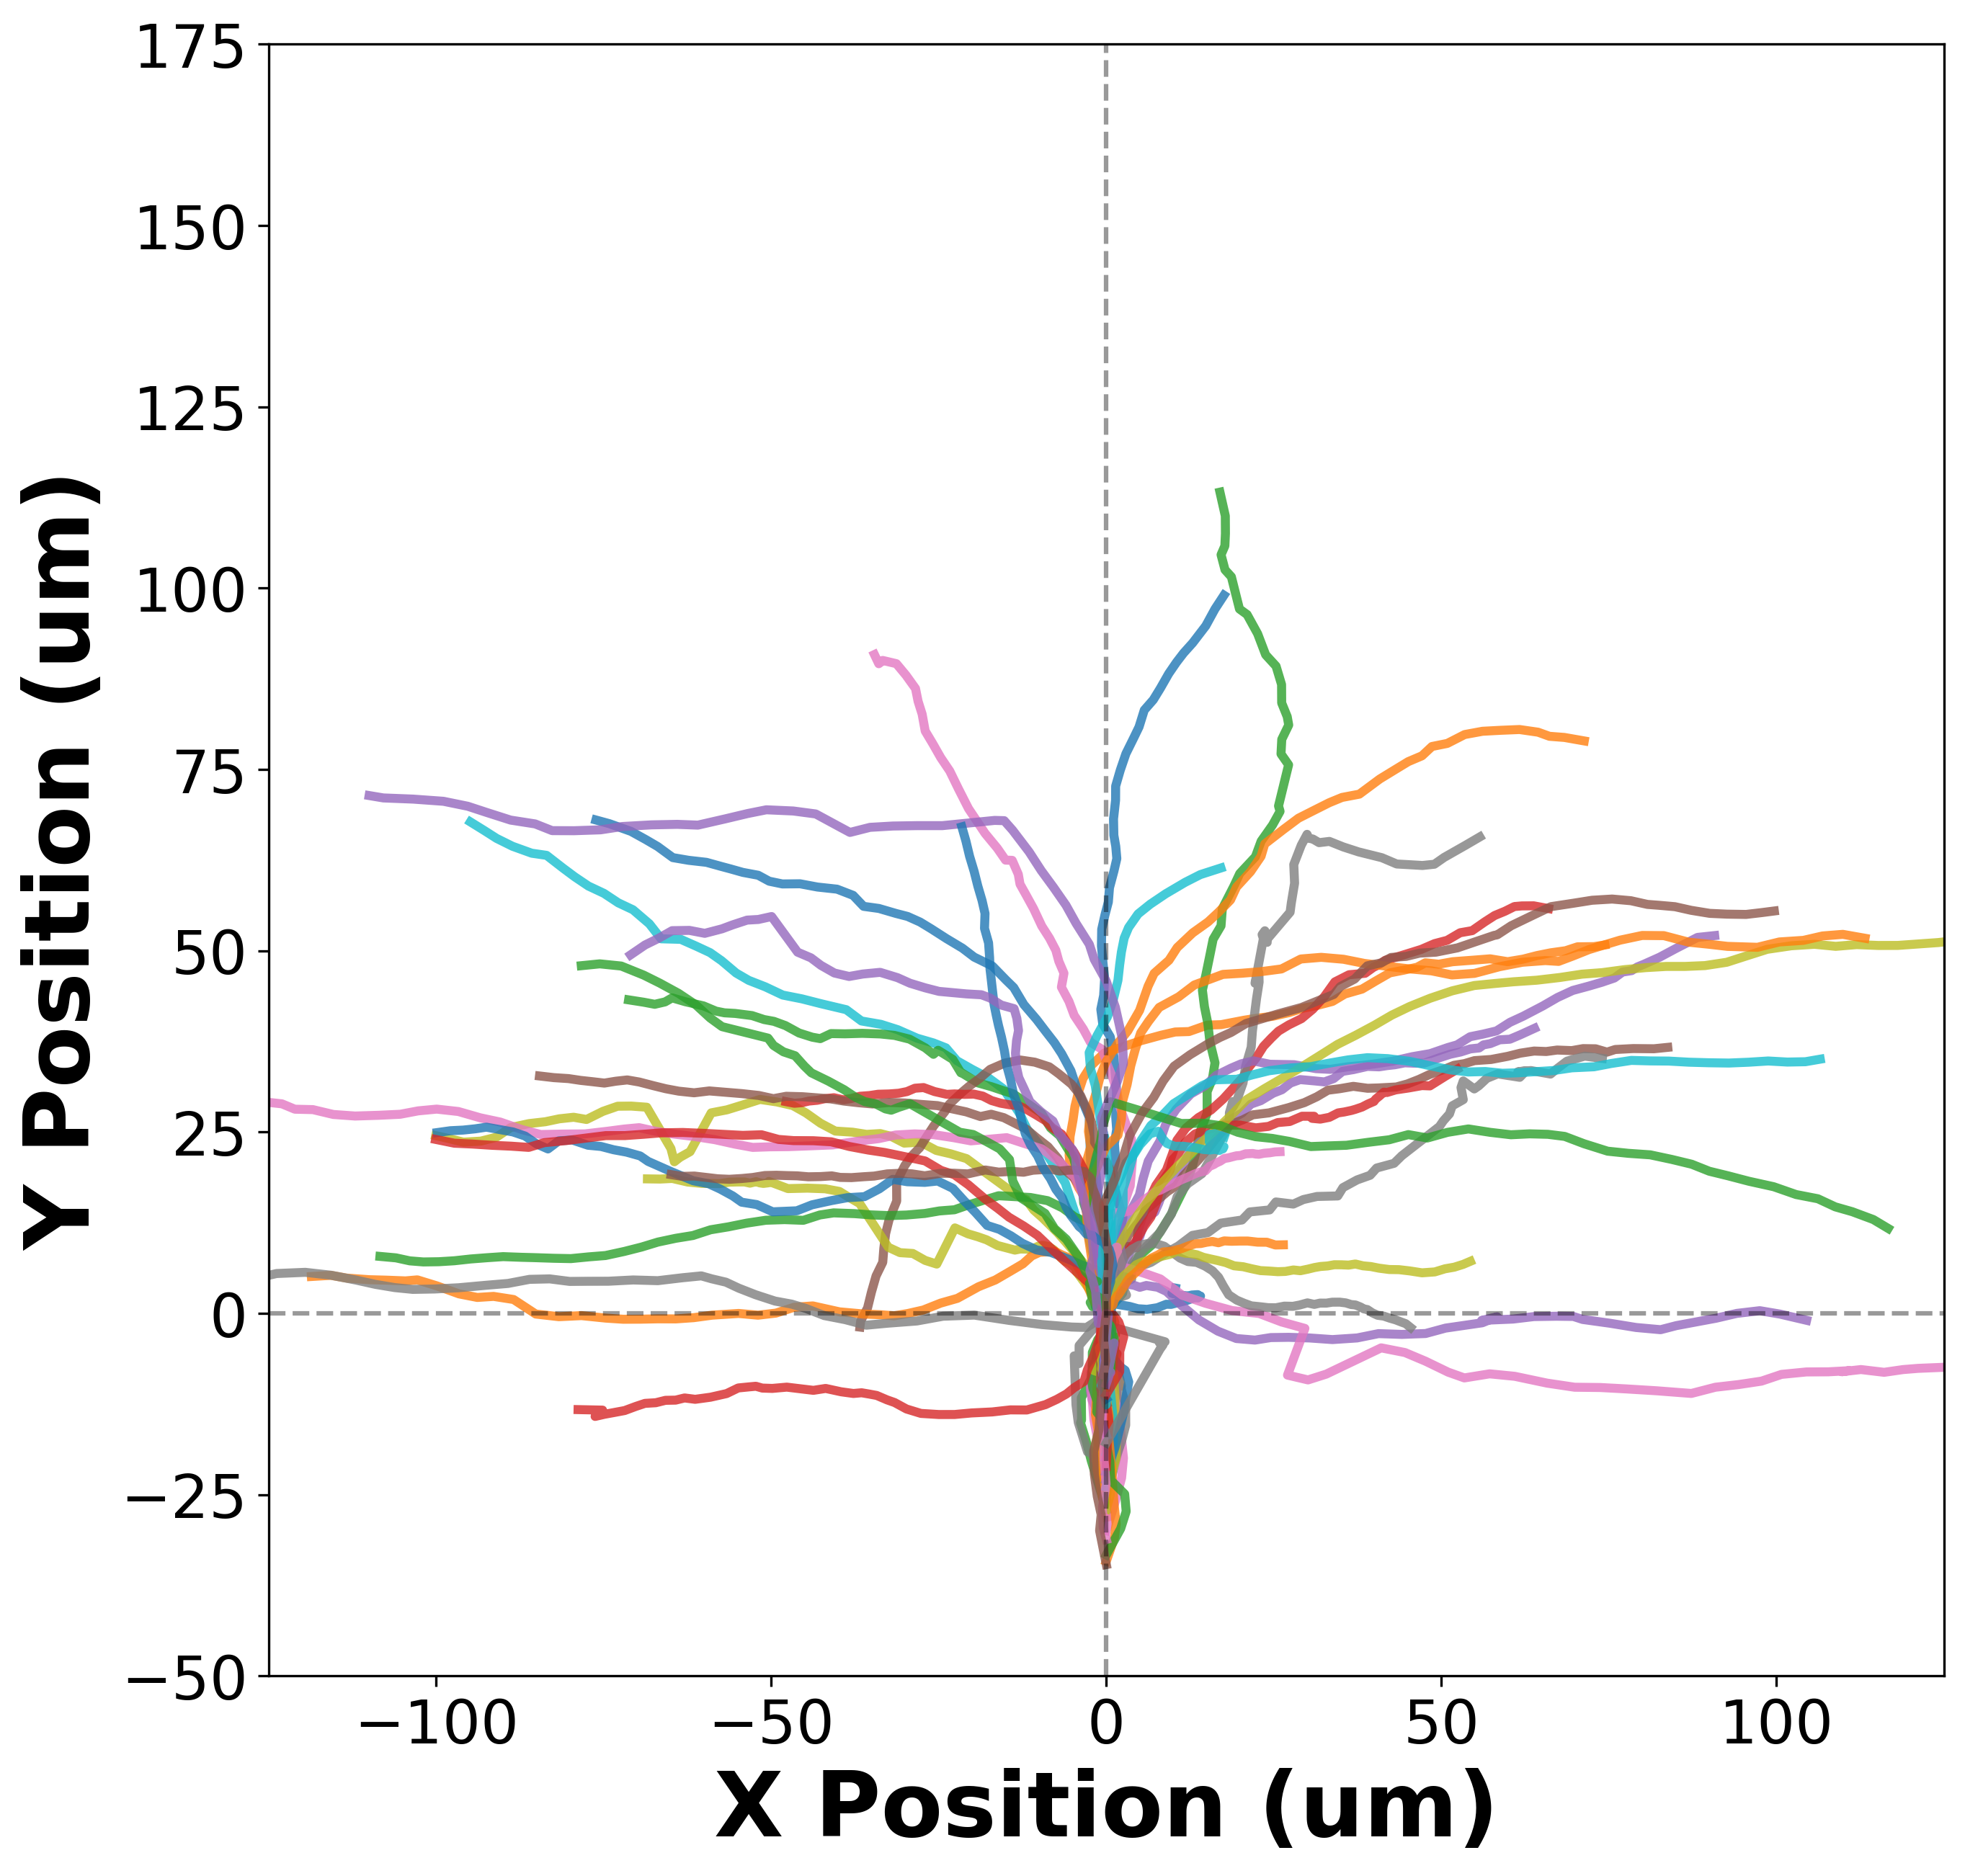

finding paths containing: "_lateral45_50000_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_016 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_007 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_002 302
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral45_50000_Intensity_005 302
/home/jason/Data/

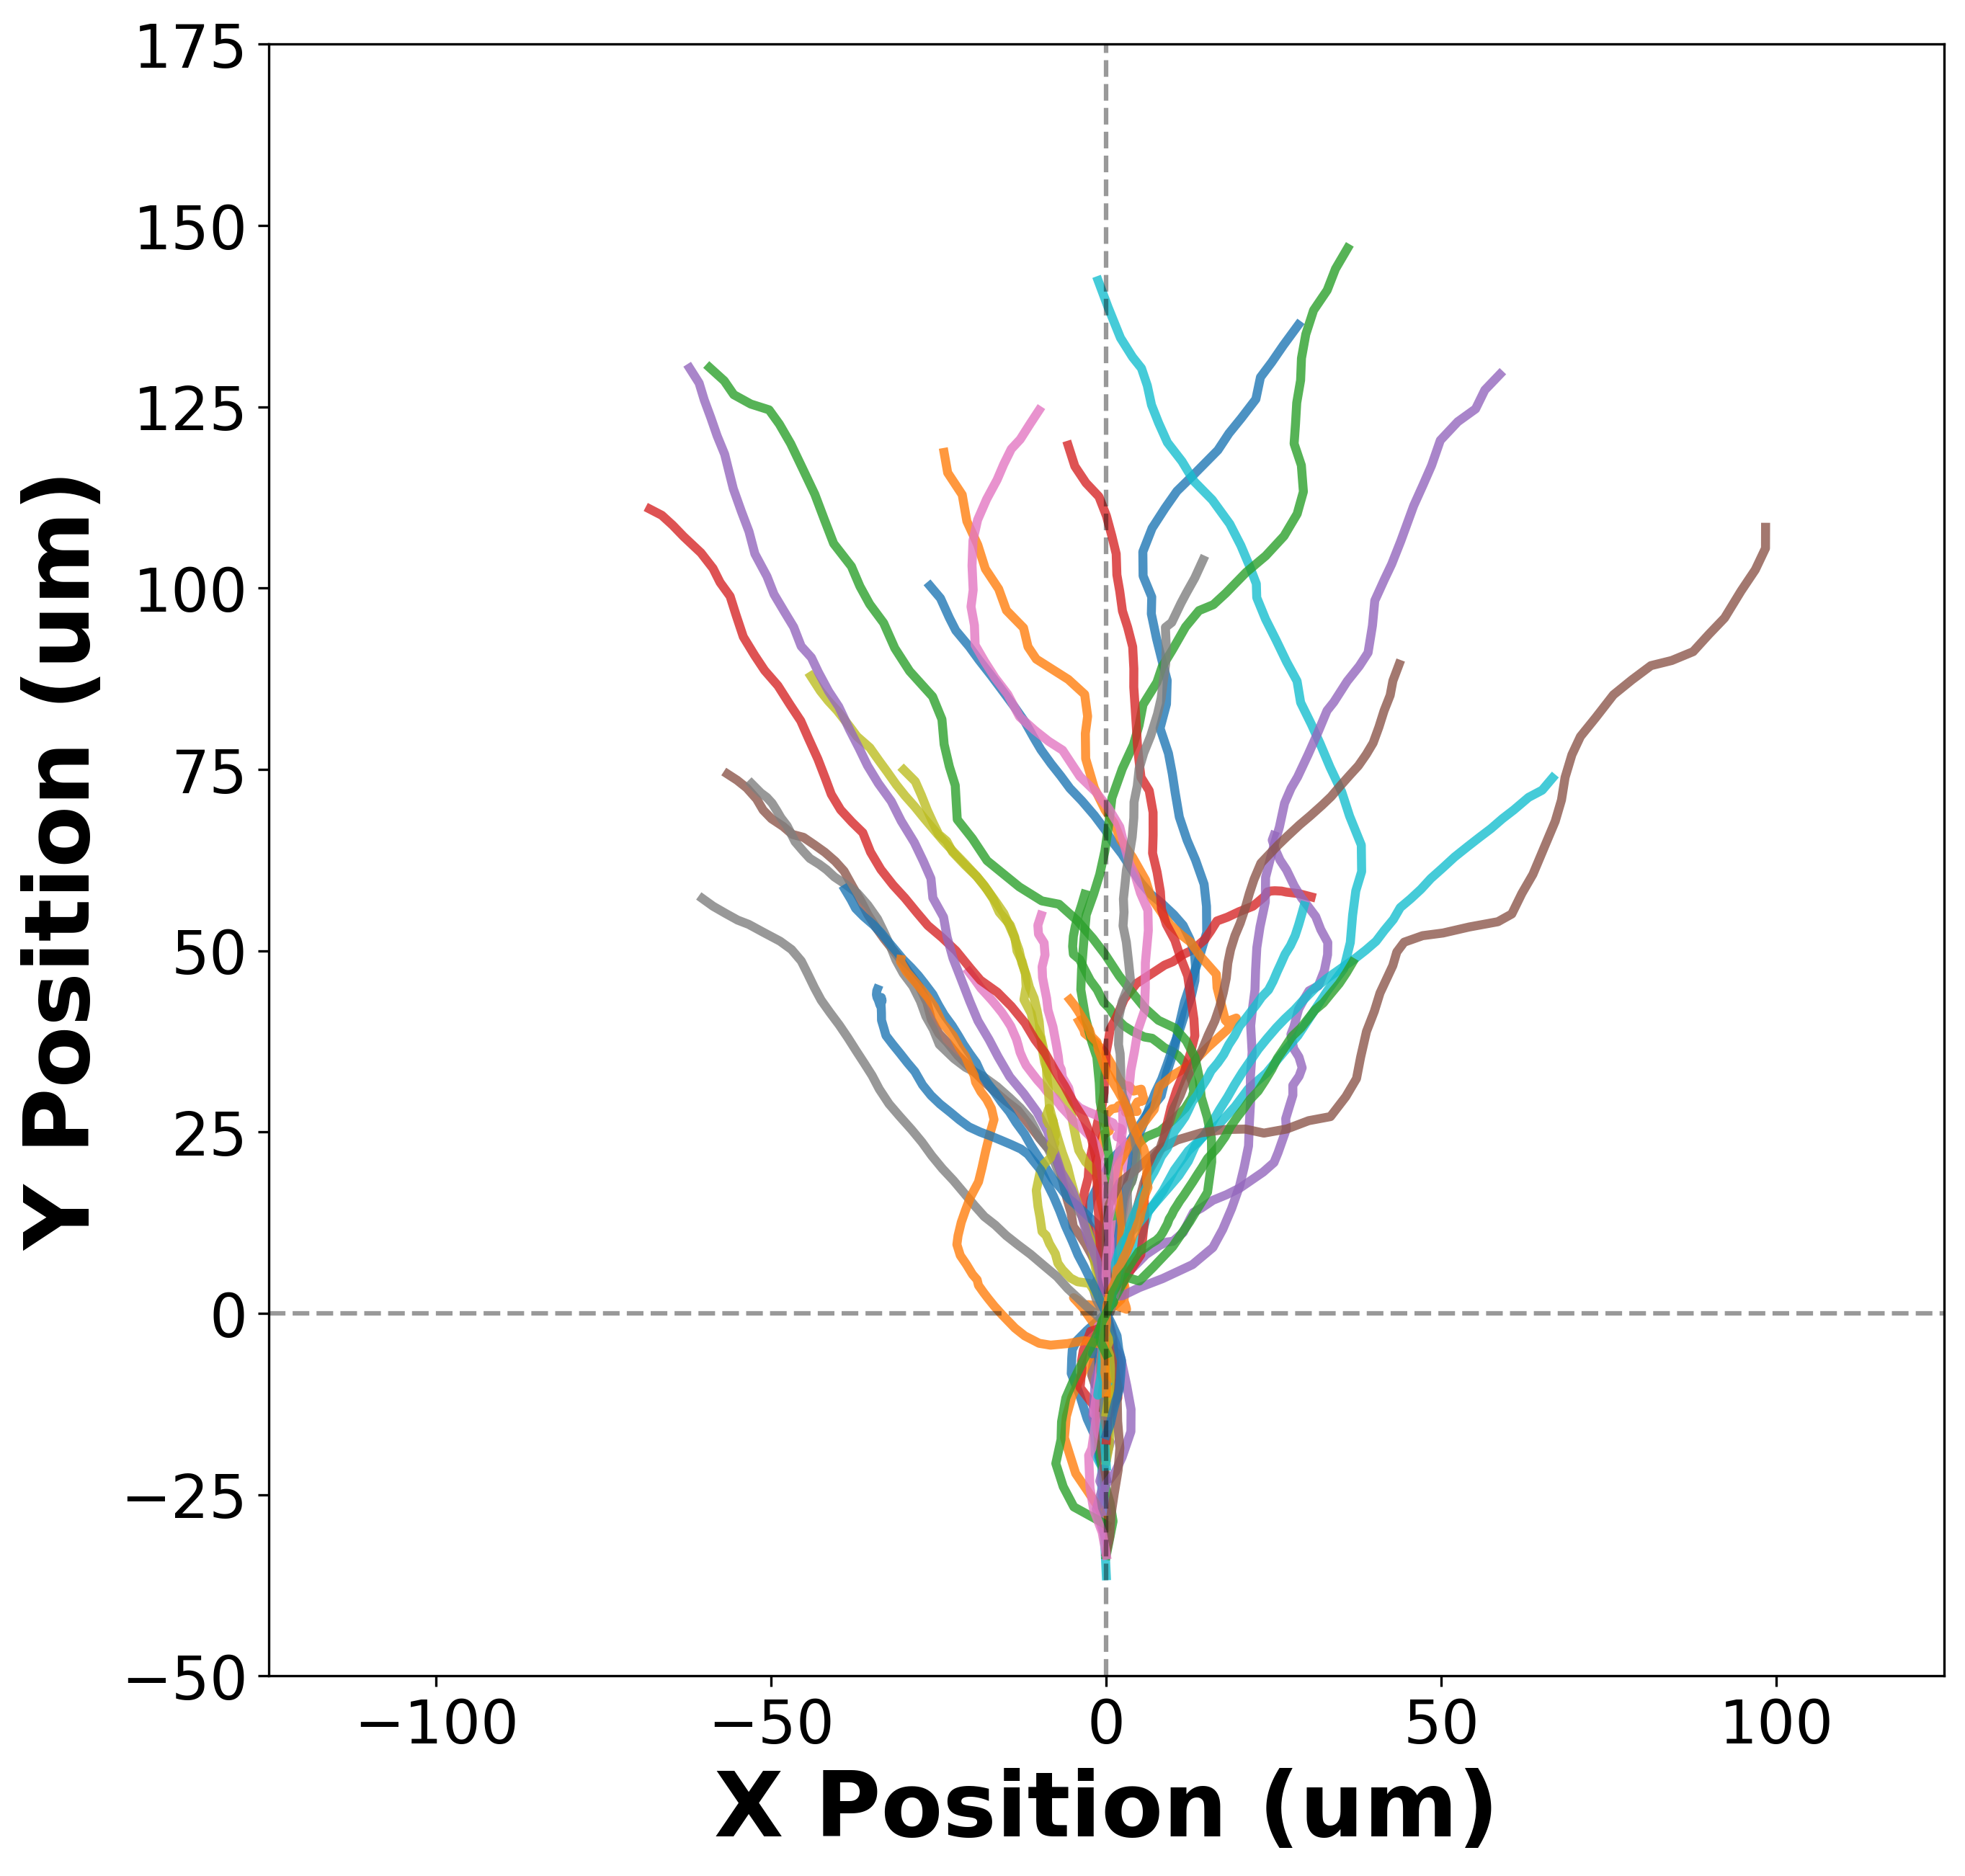

In [22]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################

# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['_lateral90_50000_', '_lateral45_50000_']

ALL_PATHS = []

for condition in different_conditions:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    if (condition == '_lateral90_50000_'):
        for i in DATA:
            if (condition in i) or ('_0Rad_' in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
        
    else:
        for i in DATA:
            if (condition in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
                    
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    ALL_PATHS.append(exp_to_analyze)

    # instantiate a figure
    plt.figure(figsize = (10, 10), dpi = 300)
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
        
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)

        plt.plot(x_rotated, y_rotated, alpha = 0.8, lw = 3)
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
        
    #plt.plot(np.average(ALL_X_PATHS, axis = 0), np.average(ALL_Y_PATHS, axis = 0), c = 'C0', lw = 6)
    
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4)
    plt.axis([-125, 125, -50, 175])
    plt.xlabel('X Position (um)', fontweight = 'bold', fontsize = 30)
    plt.ylabel('Y Position (um)', fontweight = 'bold', fontsize = 30)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    
    
    
    if condition == '_lateral90_50000_':
        X_90 = ALL_X_PATHS.copy()
        Y_90 = ALL_Y_PATHS.copy()
    if condition == '_lateral45_50000_':
        X_45 = ALL_X_PATHS.copy()
        Y_45 = ALL_Y_PATHS.copy()

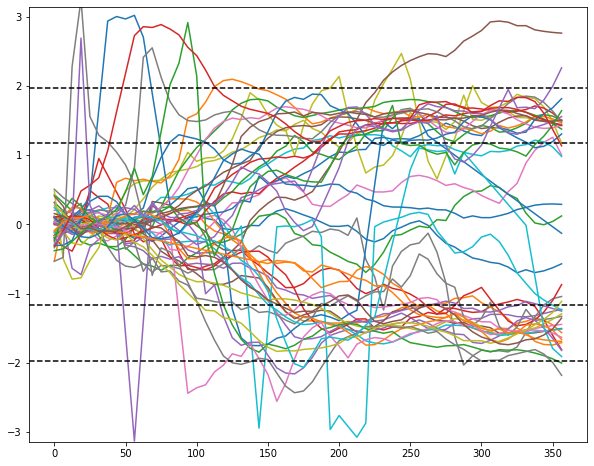

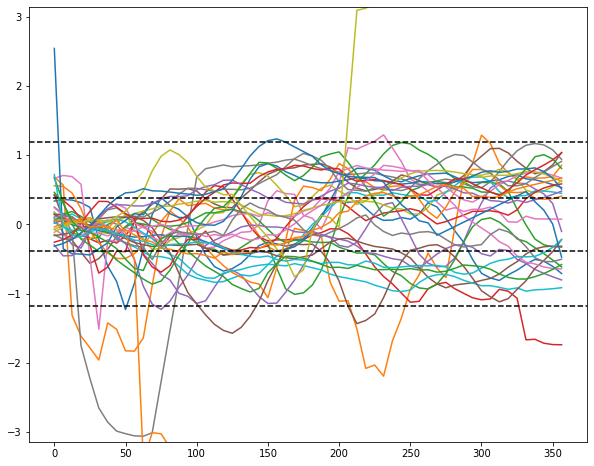

In [23]:

RAD_CUTOFF = 0.4
SPD_CUTOFF = 2

plt.figure(figsize = (10, 8))
N = 10

T = 6.25*np.arange(len(X_90[N]))
X = np.array([X_90[N], Y_90[N]]).T

xprime = [savgol_filter(X_90[N], 9, 3) for N in range(len(X_90))]
yprime = [savgol_filter(Y_90[N], 9, 3) for N in range(len(Y_90))]
spd_prime = np.hypot(np.diff(yprime, axis = 1), np.diff(xprime, axis = 1))/(6.25/60.)
ang_prime = np.arctan2(-np.diff(yprime, axis = 1), np.diff(xprime, axis = 1)) + math.pi/2
ang_prime = np.arctan2(-np.sin(ang_prime), np.cos(ang_prime))
ang_prime[spd_prime < 2] = np.nan

processed_angles_90 = []
for i in range(len(ang_prime)):
    ang_prime[i][spd_prime[i] < SPD_CUTOFF] = np.nan
    mask = np.isnan(ang_prime)
    ang_prime[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), ang_prime[~mask])

    A = np.unwrap(ang_prime[i][1:])
    plt.plot(6.25 * np.arange(len(A)), A)
    processed_angles_90.append(A)
    
plt.axhline(math.pi/2 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(math.pi/2 - RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/2 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/2 - RAD_CUTOFF, ls = '--', color = 'k')
plt.ylim(-math.pi, math.pi)
plt.show()




plt.figure(figsize = (10, 8))
N = 10

T = 6.25*np.arange(len(X_45[N]))
X = np.array([X_45[N], Y_45[N]]).T

xprime = [savgol_filter(X_45[N], 9, 3) for N in range(len(X_45))]
yprime = [savgol_filter(Y_45[N], 9, 3) for N in range(len(Y_45))]
spd_prime = np.hypot(np.diff(yprime, axis = 1), np.diff(xprime, axis = 1))/(6.25/60.)
ang_prime = np.arctan2(-np.diff(yprime, axis = 1), np.diff(xprime, axis = 1)) + math.pi/2
ang_prime = np.arctan2(-np.sin(ang_prime), np.cos(ang_prime))
ang_prime[spd_prime < 2] = np.nan

processed_angles_45 = []
for i in range(len(ang_prime)):
    ang_prime[i][spd_prime[i] < SPD_CUTOFF] = np.nan
    mask = np.isnan(ang_prime)
    ang_prime[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), ang_prime[~mask])

    A = np.unwrap(ang_prime[i][1:])
    plt.plot(6.25 * np.arange(len(A)), A)
    processed_angles_45.append(A)
    
plt.axhline(math.pi/4 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(math.pi/4 - RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/4 + RAD_CUTOFF, ls = '--', color = 'k')
plt.axhline(-math.pi/4 - RAD_CUTOFF, ls = '--', color = 'k')
plt.ylim(-math.pi, math.pi)
plt.show()

/tmp/ipykernel_246735/2337727359.py:14: RuntimeWarning: invalid value encountered in true_divide
  percent_time_aligned_with_left_45 = L/(R + L)
/tmp/ipykernel_246735/2337727359.py:28: RuntimeWarning: invalid value encountered in true_divide
  percent_time_aligned_with_left_90 = L/(R + L)


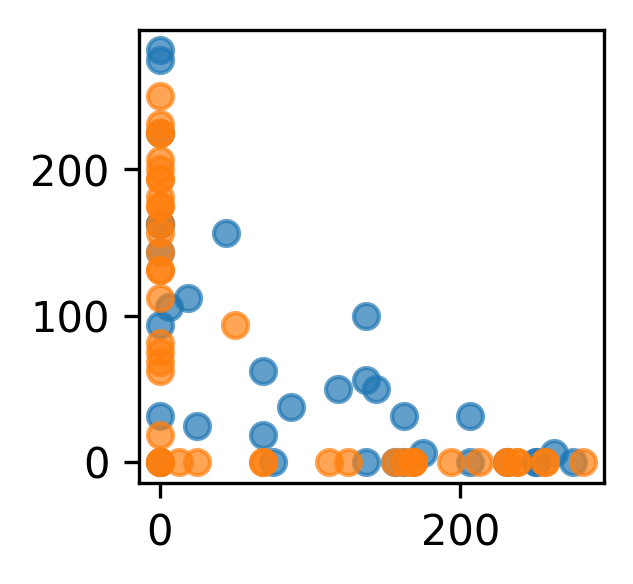

In [30]:
plt.figure(figsize = (2, 2), dpi = 300)

right = np.abs(np.array(processed_angles_45)[:,10:] - math.pi/4) < RAD_CUTOFF
left = np.abs(np.array(processed_angles_45)[:,10:] + math.pi/4) < RAD_CUTOFF
#plt.imshow(right)
#plt.show()
#plt.imshow(left)
#plt.show()

R = 6.25*np.sum(right, axis = 1)
L = 6.25*np.sum(left, axis = 1)
plt.scatter(R, L, alpha = 0.7)

percent_time_aligned_with_left_45 = L/(R + L)

right = np.abs(np.array(processed_angles_90)[:,10:] - math.pi/2) < RAD_CUTOFF
left = np.abs(np.array(processed_angles_90)[:,10:] + math.pi/2) < RAD_CUTOFF
#plt.imshow(right)
#plt.show()
#plt.imshow(left)
#plt.show()


R = 6.25*np.sum(right, axis = 1)
L = 6.25*np.sum(left, axis = 1)
plt.scatter(R, L, alpha = 0.7)

percent_time_aligned_with_left_90 = L/(R + L)

#plt.xlabel('Time Aligned with Left Spot (s)', fontweight = 'bold', fontsize = 15)
#plt.ylabel('Time Aligned with Right Spot (s)', fontweight = 'bold', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

0.08695652173913043
0.48484848484848486
[0.08142804 0.17051776]


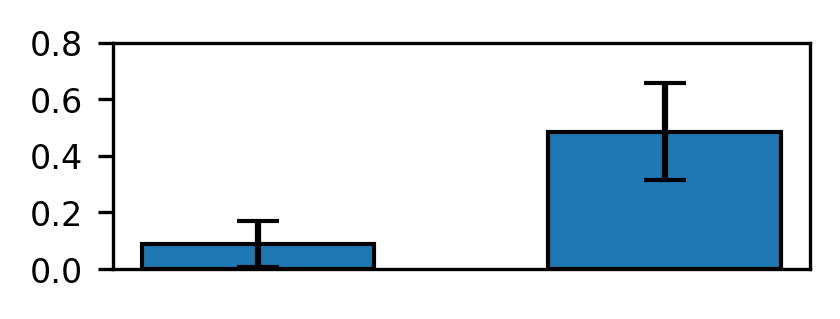

In [25]:
aligned_90 = (percent_time_aligned_with_left_90 != 1) & (percent_time_aligned_with_left_90 != 0)
print(np.sum(aligned_90)/len(aligned_90))

aligned_45 = (percent_time_aligned_with_left_45 != 1) & (percent_time_aligned_with_left_45 != 0)
print(np.sum(aligned_45)/len(aligned_45))

proportions_across_data = np.array([np.sum(aligned_90)/len(aligned_90), np.sum(aligned_45)/len(aligned_45)])
num_across_data = np.array([len(aligned_90), len(aligned_45)])

#Standard Error of Sample Proportion
sample_error = np.sqrt(proportions_across_data * (1 - proportions_across_data) / num_across_data)
percent_confidence_interval_95 = 1.96 * sample_error
print(percent_confidence_interval_95)

plt.figure(figsize = (3, 1), dpi = 300)
plt.bar([0, 1.4], proportions_across_data, yerr = percent_confidence_interval_95, capsize = 5, ec = 'k')
plt.ylim(0, 0.8)
plt.xticks([])
plt.xlim(-0.5, 1.9)
#plt.ylabel('Proportion of\nCells That Reverse\nat Least Once', fontweight = 'bold', fontsize = 15)
#plt.xticks([0, 1.4], ['180-Degree-Opposed', 'Frontward-Oriented'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize = 8)
plt.show()



In [26]:
# Two sample Z-test for proportions

p_a = np.sum(aligned_90)/len(aligned_90)
p_b = np.sum(aligned_45)/len(aligned_45)
p_c = (np.sum(aligned_90) + np.sum(aligned_45))/(len(aligned_90) + len(aligned_45))

Z = (p_a - p_b) / np.sqrt(p_c * (1- p_c) * (1/len(aligned_90) +1/len(aligned_45)))
print(stats.norm.sf(abs(Z)))

3.0206306151393525e-05


# Figure 2E

finding paths containing: "_front_"

/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_011 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_009 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_017 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_front_50000_Intensity_007 302
/home/jason/Data/simpleStimData/220214_KWC_35-52-97_simpleS

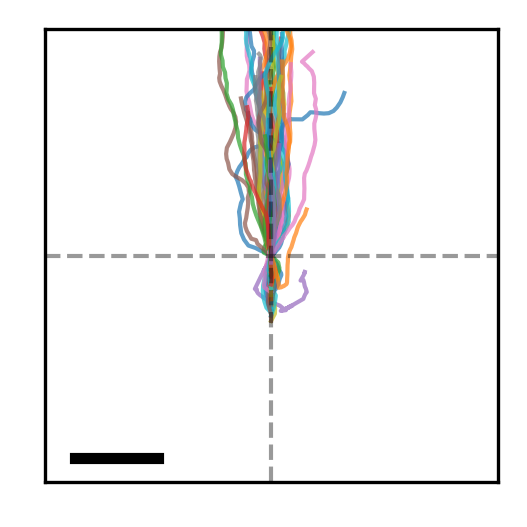

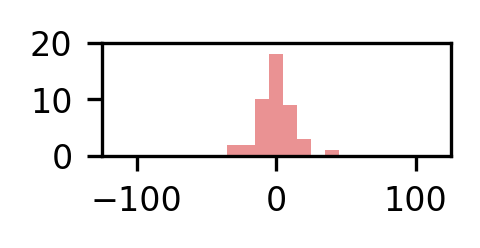

finding paths containing: "_global_"

/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_000 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_014 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_010 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_012 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_005 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_015 302
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_global_50000_Intensity_004 302
/home/jason/Data/simpleStimData/220620_KWC_35-52-97_mcPak_VariousFrontStimulations_global_50000_Intensity_003 302
/home/jason/Data/simpleStimData/220621_KWC_35-52-97_mcPak_VariousFrontStimulat

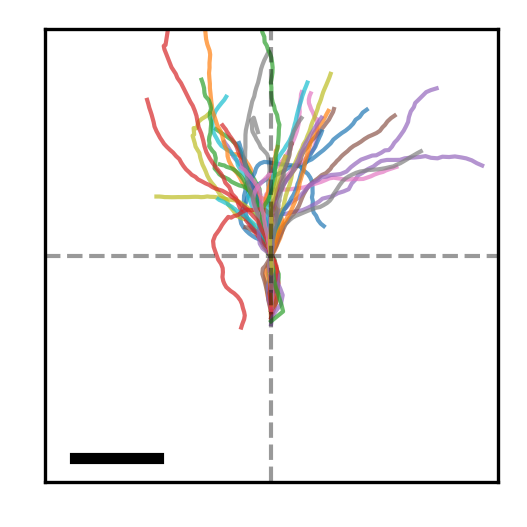

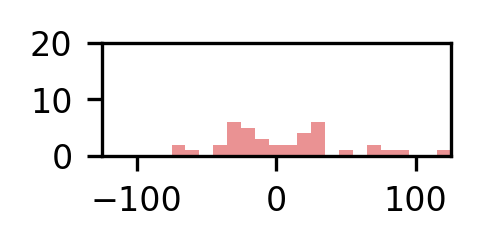

In [28]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################


different_conditions = ['_none_', '_front_', '_side_', '_back_', '_global', '_lateral90_', '_lateral45_']


exp_cond = []
file_id = []
file_id_num = []
frame = []
time = []
x_um = []
y_um = []

for condition in ['_front_', '_global_']:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    
    if (condition == '_lateral90_'):
        for i in DATA:
            if (condition in i) or ('_0Rad_' in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
        
    else:
        for i in DATA:
            if (condition in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)

                
                
                
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (2,2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder - something strange happens with some filenames and these need to be "decoded"
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        # fluorescence channel
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []
        t_stage_sequence = []
        
        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])
                tval = float(temptif.shaped_metadata[0]['elapsed_time_s'])
                
                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
                t_stage_sequence.append(tval)
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)

        plt.plot(x_rotated, y_rotated, alpha = 0.7, lw = 1)
        ALL_X_PATHS.append(x_rotated)
        ALL_Y_PATHS.append(y_rotated)
         
        for ix in range(len(x_rotated)):
            exp_cond.append(condition)
            file_id.append(exp_to_analyze[fnum].split('/')[-1])
            file_id_num.append(fnum)
            frame.append(ix)
            time.append(t_stage_sequence[ix])
            x_um.append(x_rotated[ix])
            y_um.append(y_rotated[ix])
        
    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-125, 125, -125, 125])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)
    


    rect = mp.Rectangle((-110, -114), 50, 4, color = 'k')
    ax.add_patch(rect)
    #ax.text(-120 + 50/2, -110, '50 µm', ha = 'center', va = 'bottom', fontweight='bold')
    plt.show()
    #txt = str(np.round(a.ch0_times[i] - a.ch0_times[10], 1))
    #ax.text(-100, 115, txt + ' s', va = 'top', ha = 'right', fontweight='bold')
    
    flp = np.array([i[-1] for i in ALL_X_PATHS])

    plt.figure(figsize = (1.5, 0.5), dpi = 300)
    B = np.linspace(-125, 125, 26)
    #plt.hist(flp[ids == 1], alpha = 0.5, bins = B, color = 'C3')
    plt.hist(flp, alpha = 0.5, bins = B, color = 'C3')

    plt.xticks(size = 8)
    plt.yticks([0, 10, 20], size = 8)
    plt.axis([-125, 125, 0, 20])
    plt.show()

